In [ ]:
%load_ext autoreload
%autoreload 2
import os
os.chdir("drive/MyDrive/fyp/src")

In [2]:
from data import PolygonSentenceReader, Polygon
from modules import NLLLoss, ELBOLoss, MLP
from neural_process.models.np import CNP, LNP
from neural_process.models.attnnp import AttnCNP, AttnLNP
from utils import plot_polygon

import datetime
from functools import partial
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.distributions.kl import kl_divergence

In [5]:
TRAINING_ITERATIONS = int(3e5)
PLOT_AFTER = int(2e4)
BATCH_SIZE = 128
MAX_CONTEXT_POINTS = 20
MIN_SIDES = 3
MAX_SIDES = 8
x_size = 5 + 4 * MAX_SIDES
y_size = x_size
r_size = 320
torch.manual_seed(0)

criterion = NLLLoss()

# Instantiate a polygon generator.
# (For example, polygons with between 3 and 8 sides.)
polygon_generator_train = PolygonSentenceReader(
    batch_size=BATCH_SIZE,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES,
    max_num_sides=MAX_SIDES,
    center=(5, 5),
    radius=3,
    testing=False,
)

polygon_generator_test = PolygonSentenceReader(
    batch_size=100,
    max_num_context=MAX_CONTEXT_POINTS,
    max_seq_len=x_size,
    min_num_sides=MIN_SIDES+1,
    max_num_sides=MIN_SIDES+1,
    center=(5, 5),
    radius=3,
    testing=True,
)

Decoder = partial(
    MLP,
    n_hidden_layers=8,
    hidden_size=r_size,
    dropout=0.1,
    is_res=True,
)

Encoder = partial(
    MLP,
    n_hidden_layers=7,
    hidden_size=r_size,
    dropout=0.1,
    is_res=True,
)

model = CNP(x_dim=x_size, y_dim=y_size, r_dim=r_size, Decoder=Decoder, Encoder=Encoder)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=TRAINING_ITERATIONS, eta_min=1e-6
)
model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))
device = next(model.parameters()).device
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

Total parameters: 1,600,394


# Training

## Masked Completion

In [7]:
train_losses = []
test_losses  = []
iters_list = []

checkpoint = True

if checkpoint:
    ckpt = torch.load(model.__class__.__name__ + "_masked_completion_task_checkpoint.pt",
                        map_location=device)

    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    scheduler.load_state_dict(ckpt['scheduler_state_dict'])
    start_iter = ckpt['iteration'] + 1
    model.to(device)
    print("Loaded checkpoint from: " + "../models/polygon/np/" + model.__class__.__name__ + "_checkpoint.pt")
else:
    start_iter = 1

# ----------------------
# Training Loop
# ----------------------

progress_bar = tqdm(range(start_iter, TRAINING_ITERATIONS + 1), desc="Training", unit="iter")
for it in progress_bar:
    # Generate a batch of polygon completion tasks.
    (
        context_x,
        context_y,
        target_x,
        target_y,
        tokens,
        true_poly,
        max_seq_len,
        num_context,
        context_masks,
    ) = polygon_generator_train.generate_polygon_batch_few_shot_masked_completion_task()

    context_x = context_x.to(device)
    context_y = context_y.to(device)
    target_x = target_x.to(device)
    target_y = target_y.to(device)
    context_masks = context_masks.to(device)

    optimizer.zero_grad()
    # Forward pass: the NP model expects context_x, context_y, target_x, target_y.
    dist, z, q_zc, q_zct = model(context_x, context_y, target_x, target_y)
    loss = criterion(dist, target_y, mask=context_masks)
    loss.backward()

    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()

    train_losses.append(loss.item())

    if it % 1000 == 0:
        now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        progress_bar.set_postfix({"Iteration": it, "Train Loss": f"{loss.item():.4f}", "LR": f"{scheduler.get_last_lr()[0]:.6f}"})

    # ----------------------
    # Evaluation and Plotting
    # ----------------------
    if it % PLOT_AFTER == 0:
        # For plotting, we generate a single polygon sample.
        (
            context_x_eval,
            context_y_eval,
            target_x_eval,
            target_y_eval,
            tokens_eval,
            true_poly_eval,
            max_seq_len_eval,
            num_context_eval,
            context_masks_eval,
        ) = polygon_generator_test.generate_polygon_batch_few_shot_masked_completion_task()

        context_x_eval = context_x_eval.to(device)
        context_y_eval = context_y_eval.to(device)
        target_x_eval = target_x_eval.to(device)
        target_y_eval = target_y_eval.to(device)
        context_masks_eval = context_masks_eval.to(device)

        # Forward pass through the model.
        test_dist, test_z, test_q_zc, test_q_zct = model(
            context_x_eval, context_y_eval, target_x_eval, target_y_eval
        )
        loss_eval = criterion(test_dist, target_y_eval, mask=context_masks_eval)
        test_losses.append(loss_eval.item())
        iters_list.append(it)

        # Get NP predictions on target tokens (taking the mean of the predictive distribution).
        pred_target = test_dist.mean  # shape: [n_z, batch, n_target, y_dim]

        # For simplicity, we average over latent samples and batch dimension.
        pred_target_avg = pred_target.mean(0)[0, -1, :]  # shape: [batch, n_target, y_dim]
        true_polygon = true_poly_eval[0]
        true_polygon_tokenised = true_polygon.to_tokenised()
        pred_target_avg = pred_target_avg[: len(true_polygon_tokenised)].tolist()
        # print("pred_target_avg shape after squeeze: ", pred_target_avg.shape)

        # Squeeze out the batch‐and‐context dims to get a 1D mask
        mask_1d = context_masks_eval.squeeze(1)[0].cpu().tolist()
        mask_1d = mask_1d[: len(true_polygon_tokenised)]

        # Construct predicted tokenised form
        predicted_tokens = []
        for t_true, t_pred, m in zip(
            true_polygon_tokenised, pred_target_avg, mask_1d
        ):
            # m == 1: masked token
            predicted_tokens.append(t_pred if m == 1 else t_true)

        # Reconstruct polygons from tokens.
        try:
            predicted_polygon = Polygon.from_tokenised(predicted_tokens, int(true_polygon_tokenised[0]))
        except Exception as e:
            print("Error reconstructing polygon:", e)
            predicted_polygon = None

        now = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        print(f"{now}: Iteration: {it}, Test Loss: {loss_eval.item():.4f}")
        print("True Polygon: ", true_polygon)
        if predicted_polygon is not None:
            print("Predicted Polygon Vertices: ", predicted_polygon)
        else:
            print("Predicted Polygon could not be reconstructed.")

        # Plot true and predicted polygons.
        # plot_polygon(true_polygon.vertices, title="True Polygon")
        # if predicted_polygon is not None:
        #     try:
        #         plot_polygon(predicted_polygon.vertices, title="Predicted Polygon")
        #     except Exception as e:
        #         print("Invalid polygon for plotting:", e)

Loaded checkpoint from: ../models/polygon/np/CNP_checkpoint.pt


Training:  20%|██        | 20001/100000 [36:48<2:46:04,  8.03iter/s, Iteration=220000, Train Loss=3.5288, LR=0.000003]

2025-05-12 09:52:05: Iteration: 220000, Test Loss: 5.8878
True Polygon:  Polygon(n=4, vertices=[(5.76, 7.9), (2.76, 6.99), (5.52, 2.05), (7.45, 3.26)], lengths=[3.1349800637324634, 5.6587277722117015, 2.277937663765188, 4.93818792676018], angles=[93.13854527439167, 77.68201274666336, 87.10691883436044, 102.07252314458454])
Predicted Polygon Vertices:  Polygon(n=4, vertices=[(5.76, 7.9), (2.76, 6.99), (5.52, 2.05), (7.45, 3.26)], lengths=[3.1349800637324634, 5.6587277722117015, 2.277937663765188, 4.93818792676018], angles=[13.383500099182129, 30.229732513427734, 27.929813385009766, 40.67094421386719])


Training:  40%|████      | 40001/100000 [1:13:45<2:09:39,  7.71iter/s, Iteration=240000, Train Loss=3.5966, LR=0.000010]

2025-05-12 10:29:02: Iteration: 240000, Test Loss: 5.8532
True Polygon:  Polygon(n=4, vertices=[(2.05, 4.43), (5.25, 2.01), (6.86, 2.65), (7.72, 3.74)], lengths=[4.012031904160285, 1.732541485794785, 1.3884163640637486, 5.7118298293979315], angles=[30.1600082543213, 121.22301680072813, 149.95170509061302, 58.66526985433758])
Predicted Polygon Vertices:  Polygon(n=4, vertices=[(2.05, 4.43), (5.25, 2.01), (6.86, 2.65), (7.72, 3.74)], lengths=[4.012031904160285, 1.732541485794785, 1.3884163640637486, 5.7118298293979315], angles=[13.24195384979248, 27.453718185424805, 24.96253204345703, 36.07094955444336])


Training:  60%|██████    | 60002/100000 [1:50:49<1:12:51,  9.15iter/s, Iteration=260000, Train Loss=3.5592, LR=0.000021]

2025-05-12 11:06:06: Iteration: 260000, Test Loss: 5.8228
True Polygon:  Polygon(n=4, vertices=[(8.0, 5.07), (6.68, 7.49), (3.05, 7.28), (2.52, 6.69)], lengths=[2.756592098951167, 3.6360693062701652, 0.7930952023559338, 5.7144378551175095], angles=[44.92078408037929, 115.29951815135378, 135.24445601348555, 64.5352417547814])
Predicted Polygon Vertices:  Polygon(n=4, vertices=[(8.0, 5.07), (6.68, 7.49), (3.05, 7.28), (2.52, 6.69)], lengths=[2.756592098951167, 3.6360693062701652, 0.7930952023559338, 5.7144378551175095], angles=[12.886173248291016, 27.434982299804688, 25.23400115966797, 35.46674346923828])


Training:  80%|████████  | 80001/100000 [2:27:48<37:30,  8.89iter/s, Iteration=280000, Train Loss=3.4129, LR=0.000035]

2025-05-12 11:43:05: Iteration: 280000, Test Loss: 5.7945
True Polygon:  Polygon(n=4, vertices=[(5.57, 7.94), (2.07, 5.63), (4.46, 2.05), (7.52, 3.38)], lengths=[4.193578424210045, 4.304474416232486, 3.336540124140574, 4.959445533524892], angles=[79.72827038150974, 89.69782627802603, 100.23526623857315, 90.33863710189111])
Predicted Polygon Vertices:  Polygon(n=4, vertices=[(5.57, 7.94), (2.07, 5.63), (4.46, 2.05), (7.52, 3.38)], lengths=[4.193578424210045, 4.304474416232486, 3.336540124140574, 4.959445533524892], angles=[15.060979843139648, 30.467235565185547, 28.587188720703125, 40.31111526489258])


Training: 100%|██████████| 100000/100000 [3:04:53<00:00,  9.01iter/s, Iteration=3e+5, Train Loss=3.3818, LR=0.000051]

2025-05-12 12:20:11: Iteration: 300000, Test Loss: 5.7959
True Polygon:  Polygon(n=4, vertices=[(7.05, 7.19), (6.56, 7.57), (4.94, 8.0), (2.16, 5.98)], lengths=[0.6200806399170999, 1.6760966559241137, 3.4363934582640563, 5.037479528494384], angles=[51.6922575574588, 157.07141450912303, 129.13178591332536, 22.104542020092858])
Predicted Polygon Vertices:  Polygon(n=4, vertices=[(7.05, 7.19), (6.56, 7.57), (4.94, 8.0), (2.16, 5.98)], lengths=[0.6200806399170999, 1.6760966559241137, 3.4363934582640563, 5.037479528494384], angles=[14.055347442626953, 27.862642288208008, 26.188949584960938, 36.8004264831543])


In [8]:
checkpoint = {
    'iteration': it,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
}

torch.save(model.state_dict(), model.__class__.__name__ + "_masked_completion_task_ 300k.pt")
torch.save(checkpoint, model.__class__.__name__ + "_masked_completion_task_checkpoint_300k.pt")
print(f"Saved final checkpoint at iteration {it} → " + model.__class__.__name__ + "_masked_completion_task_checkpoint_300k.pt")

Saved final checkpoint at iteration 300000 → CNP_masked_completion_task_checkpoint_300k.pt


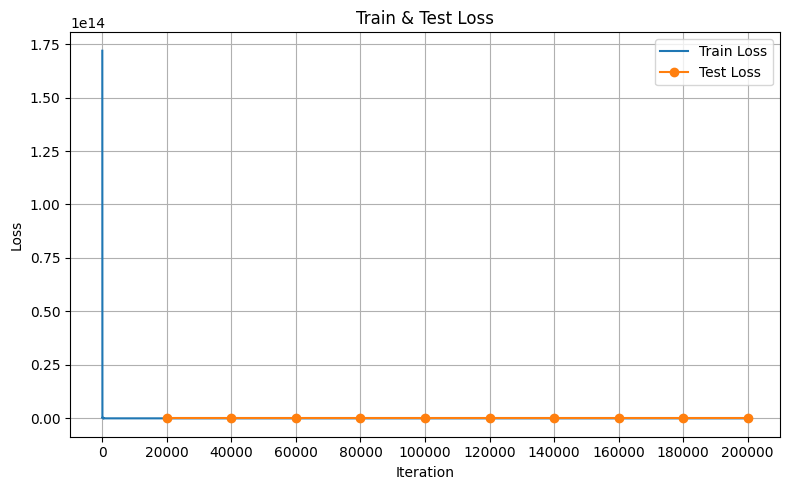

In [6]:
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(iters_list, test_losses, marker='o', label="Test Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Train & Test Loss")
plt.xticks(list(range(0, len(train_losses)+1, max(1, len(train_losses)//10))))  # optional: sparser x-ticks
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()